<a href="https://colab.research.google.com/github/DavideBruni/CIDL_lab/blob/main/Lecture2/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision


train_mnist = torchvision.datasets.MNIST(
    "./data",
    train=True,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])
)

test_mnist = torchvision.datasets.MNIST(
    "./data",
    train=False,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])
)

100%|██████████| 9912422/9912422 [00:00<00:00, 154812650.09it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 41442249.00it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 43754295.13it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 18824633.17it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# **Exercise 0**

In [2]:
model = torch.nn.Sequential(
    torch.nn.Linear(28 * 28, 300),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(300, 300),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(300, 10),
    torch.nn.Softmax(dim=1)
)

model.to("cuda")

Sequential(
  (0): Linear(in_features=784, out_features=300, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=300, out_features=300, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=300, out_features=10, bias=True)
  (5): Softmax(dim=1)
)

In [3]:
from tqdm import tqdm

dl = torch.utils.data.DataLoader(train_mnist, batch_size=32, shuffle=True)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 5

for epoch in range(5):
    bar = tqdm(dl)
    for digit, cls in bar:
        digit = digit.to("cuda")    #move to GPU!
        cls = cls.to("cuda")

        digit = digit.view(digit.shape[0], 28 * 28) #reshape!
        pred = model(digit)

        loss = loss_fn(pred, cls)
        accuracy = (pred.argmax(dim=1) == cls).float().mean()
        bar.set_description(f"Loss: {loss.item():.4f}, Accuracy: {accuracy.item():.4f}")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


Loss: 1.4612, Accuracy: 1.0000: 100%|██████████| 1875/1875 [00:22<00:00, 84.53it/s]


In [4]:
import torch.nn.functional as F

correct = 0
total = 0
model.eval()

test_loader = torch.utils.data.DataLoader(test_mnist, batch_size=32, shuffle=True)
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to("cuda")    #move to GPU!
        labels = labels.to("cuda")

        images = images.view(images.shape[0], 28 * 28)    #reshape!
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Accuracy on the test set: {accuracy * 100:.2f}%')

Accuracy on the test set: 94.44%


# **Exercise 1**

In [7]:
import random

class PointCoupleDataset(torch.utils.data.IterableDataset):
  def __init__(self,dataset):
    self.dataset = dataset

  def __iter__(self):
    return self

  def __next__(self):               # returns 2 random digits, is correct? Meh
    a_digit, a_class = random.choice(self.dataset)
    b_digit, b_class = random.choice(self.dataset)

    return a_digit, b_digit, a_class, b_class

ds = PointCoupleDataset(train_mnist)

In [8]:
model = torch.nn.Sequential(
    torch.nn.Conv2d(1,16,(3,3),padding=1),
    torch.nn.LeakyReLU(),
    torch.nn.Conv2d(16,32,(3,3),padding=1),
    torch.nn.LeakyReLU(),
    torch.nn.Conv2d(32,64,(3,3),padding=1),
    torch.nn.LeakyReLU(),
    torch.nn.Conv2d(64, 64, (3, 3), stride=2),
    torch.nn.LeakyReLU(),
    torch.nn.Flatten(),
)
model.to("cuda")

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): LeakyReLU(negative_slope=0.01)
  (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): LeakyReLU(negative_slope=0.01)
  (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): LeakyReLU(negative_slope=0.01)
  (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2))
  (7): LeakyReLU(negative_slope=0.01)
  (8): Flatten(start_dim=1, end_dim=-1)
)

In [26]:
from tqdm import trange, tqdm

epochs = 5
batches = 2000
ds = PointCoupleDataset(train_mnist)
dl = torch.utils.data.DataLoader(ds, batch_size=32)

model.to("cuda")

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
dist_fn = torch.nn.PairwiseDistance(p=2)
loss_fn = torch.nn.MSELoss()

for epoch in range(0,epochs):
    bar = tqdm(enumerate(dl), total=batches)
    for i, (a_digit, b_digit, a_cls, b_cls) in bar:
        a_digit = a_digit.to("cuda")    #move to GPU!
        b_digit = b_digit.to("cuda")    #move to GPU!
        a_cls = a_cls.to("cuda")
        b_cls = b_cls.to("cuda")

        optimizer.zero_grad()
        a_outs = model(a_digit)     #predict
        b_outs = model(b_digit)     #predict

        dist = dist_fn(a_outs, b_outs)                        #dist between features
        target_dists = (a_cls - b_cls).abs().float()      #dist between actual numbers

        loss = loss_fn(dist, target_dists)
        bar.set_description(f"Loss: {loss.item():.4f}, Accuracy: {accuracy.item():.4f}")


        loss.backward()
        optimizer.step()

        bar.set_description(f"Loss {loss.item():.4f}")

        if i >= batches:
            break


Loss 115.6908: 100%|██████████| 2000/2000 [00:57<00:00, 34.96it/s]


In [27]:
train_dl = torch.utils.data.DataLoader(train_mnist, batch_size=32, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_mnist, batch_size=32, shuffle=True)

train_features = []
train_classes = []

test_features = []
test_classes = []

for i, (digits, classes) in enumerate(train_dl):
    digits = digits.to("cuda")

    features = model(digits)
    train_features.append(features.detach().cpu().numpy())
    train_classes.append(classes.detach().cpu().numpy())

for i, (digits, classes) in enumerate(test_dl):
    digits = digits.to("cuda")

    features = model(digits)
    test_features.append(features.detach().cpu().numpy())
    test_classes.append(classes.detach().cpu().numpy())

In [28]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

train_features = np.concatenate(train_features)
test_features = np.concatenate(test_features)

train_classes = np.concatenate(train_classes)
test_classes = np.concatenate(test_classes)

train_pca = PCA(n_components=2)
train_pca = train_pca.fit_transform(train_features)

test_pca = PCA(n_components=2)
test_pca = test_pca.fit_transform(test_features)

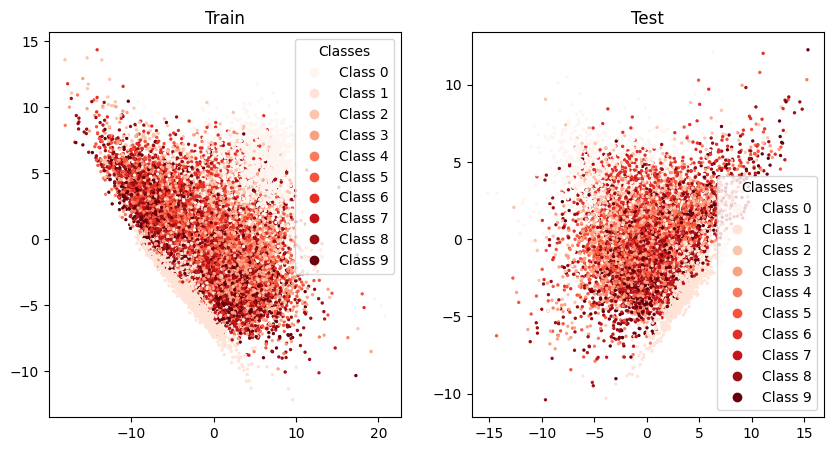

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
scatter_train = ax[0].scatter(train_pca[:, 0], train_pca[:, 1], c=train_classes, s=2, cmap="Reds")
ax[0].set_title("Train")

scatter_test = ax[1].scatter(test_pca[:, 0], test_pca[:, 1], c=test_classes, s=2, cmap="Reds")
ax[1].set_title("Test")

legend_labels = [f'Class {label}' for label in set(train_classes)]
ax[0].legend(scatter_train.legend_elements()[0], legend_labels, title="Classes")

# Puoi anche aggiungere la stessa legenda per il secondo subplot
ax[1].legend(scatter_test.legend_elements()[0], legend_labels, title="Classes")


**Bad results. Just look at the value of Loss function! In the solution propose by Galatolo he use also some MaxPool layer... and probably they are necessary, since my result are very very poor!**